# IJCNN

In [1]:
import sys
sys.path.append('/Users/IzmailovPavel/Documents/Education/Course Project/Code')
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt

from GP.covariance_functions import SquaredExponential
from GP.gaussian_process_classification import GPC

from sklearn.cluster import KMeans

from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Данные

In [2]:
x_tr, y_tr = load_svmlight_file('../../../../Programming/DataSets/Classification/ijcnn1(49990,22).txt')
x_tr, y_tr = shuffle(x_tr, y_tr, random_state=241)
x_test, y_test = load_svmlight_file('../../../../Programming/DataSets/Classification/ijcnn1_test(91701,22).txt')
x_test, y_test = shuffle(x_test, y_test, random_state=230)
x_test = x_test[:8000, :]
y_test = y_test[:8000]
data_name = 'ijcnn'

x_tr = x_tr.toarray()
x_test = x_test.toarray()
scaler = StandardScaler()
x_tr = scaler.fit_transform(x_tr).T
x_test = scaler.transform(x_test).T

x_tr = (x_tr + 1) / 2
x_test = (x_test + 1) / 2
y_tr = y_tr[:, None]
y_test = y_test[:, None]
y_tr[y_tr == 0] = -1
y_test[y_test == 0] = -1
dim, num = x_tr.shape

print('of objects:', num)
print('of features:', dim)
print(data_name)

of objects: 35000
of features: 22
ijcnn


## K-Means cluster centers

In [3]:
ind_num = 100
print('Finding means...')
means = KMeans(n_clusters=ind_num, n_init=3, max_iter=100, random_state=241)
means.fit(x_tr.T)
inputs = means.cluster_centers_.T
print('...found')

Finding means...
...found


In [31]:
cov_params = np.array([10., 20., .1])

## svi-L-BFGS-B-c method

In [33]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
svi_gp = GPC(model_covariance_obj, method='svi')

In [ ]:
opts = {'mode': 'full', 'maxiter': 100, 'mydisp': True}
svi_res = svi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Hyper-parameters at iteration 0 : [ 10.   20.    0.1   0.    0. ]
Hyper-parameters at iteration 1 : [  1.00012780e+01   1.99962267e+01   5.21819681e-01  -1.94654840e-02
  -1.16229340e-01]
Hyper-parameters at iteration 2 : [  9.97990063  19.99353314   0.26460446  -0.16966981  -0.80989622]
Hyper-parameters at iteration 3 : [  9.97719232  19.98869996   0.17598408  -0.24182403  -1.10739343]
Hyper-parameters at iteration 4 : [  9.97600085  19.98146191   0.18842116  -0.33011074  -1.46743958]
Hyper-parameters at iteration 5 : [  9.97489348  19.96836291   0.25521643  -0.50467553  -2.017685  ]
Hyper-parameters at iteration

In [28]:
metric = lambda w: svi_gp.get_prediction_quality(w, x_test, y_test)
svi_x_lst, svi_y_lst = svi_res.plot_performance(metric, 't', freq=1)

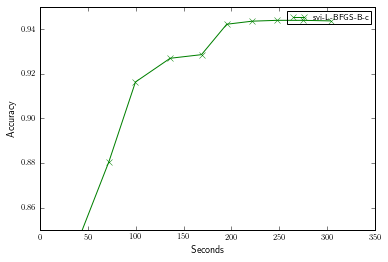

In [29]:
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.85, .95])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## vi-means-c method
Подбор числа пересчетов

In [31]:
maxfuns = [5, 10, 15, 20]
results = []
for maxfun in maxfuns:
    print(maxfun)
    model_covariance_obj = SquaredExponential(np.copy(cov_params))
    vi_gp = GPC(model_covariance_obj, method='vi')
    opts = {'maxfun':maxfun, 'mydisp': True, 'num_updates':3}
    results.append(vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=7))
    print()

5
Hyper-parameters at iteration 0 : [ 10.   20.    0.1]
	Hyper-parameters at outter iteration 0 : [ 10.   20.    0.1]
Hyper-parameters at iteration 0 : [ 10.   20.    0.1]
Hyper-parameters at iteration 1 : [ 22.98070246  13.4171241    0.07036224]
	Hyper-parameters at outter iteration 1 : [  2.38945599e+01   1.29453125e+01   1.00000000e-02]
Hyper-parameters at iteration 0 : [  2.38945599e+01   1.29453125e+01   1.00000000e-02]
Hyper-parameters at iteration 1 : [  2.42633333e+01   1.22886593e+01   1.00000000e-02]
	Hyper-parameters at outter iteration 2 : [  2.55060059e+01   1.00758467e+01   1.00000000e-02]
Hyper-parameters at iteration 0 : [  2.55060059e+01   1.00758467e+01   1.00000000e-02]
Hyper-parameters at iteration 1 : [  2.53599060e+01   1.08521287e+01   1.00000000e-02]
	Hyper-parameters at outter iteration 3 : [  2.53591311e+01   1.08562391e+01   1.00000000e-02]
Hyper-parameters at iteration 0 : [  2.53591311e+01   1.08562391e+01   1.00000000e-02]
Hyper-parameters at iteration 1 :

/Users/IzmailovPavel/Documents/Education/Course Project/Code/GP/optimization.py:367: OptimizeWarning: Unknown solver options: num_recomputes
  out = op.minimize(func, x0, jac=jac, callback=callback, **kwargs)


0
1
2
3


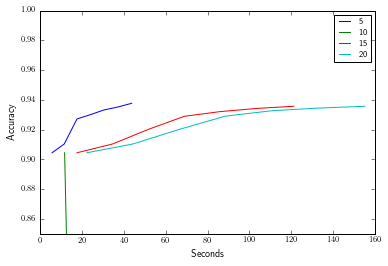

In [37]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
for i in range(len(maxfuns)):
    vi_x_lst, vi_y_lst = results[i].plot_performance(metric, 't', freq=1)
    plt.plot(vi_x_lst[1:], vi_y_lst[1:], label=maxfuns[i])
    print(i)
plt.ylim([0.85, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

Обучение лучшего варианта

In [48]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi')
opts = {'maxfun':5, 'mydisp': True, 'num_updates':3}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=20)

Hyper-parameters at iteration 0 : [ 10.   20.    0.1]
	Hyper-parameters at outter iteration 0 : [ 10.   20.    0.1]
Hyper-parameters at iteration 0 : [ 10.   20.    0.1]
Hyper-parameters at iteration 1 : [ 15.34724139  17.28252779   0.08776526]
	Hyper-parameters at outter iteration 1 : [ 25.04423088  12.34747978   0.0630691 ]
Hyper-parameters at iteration 0 : [ 25.04423088  12.34747978   0.0630691 ]
Hyper-parameters at iteration 1 : [ 25.59073785  11.56181394   0.05410709]
Hyper-parameters at iteration 2 : [  2.48322021e+01   1.26534443e+01   1.00000000e-02]
	Hyper-parameters at outter iteration 2 : [  2.48345551e+01   1.26500577e+01   1.00000000e-02]
Hyper-parameters at iteration 0 : [  2.48345551e+01   1.26500577e+01   1.00000000e-02]
	Hyper-parameters at outter iteration 3 : [  2.48345551e+01   1.26500577e+01   1.00000000e-02]
Hyper-parameters at iteration 0 : [  2.48345551e+01   1.26500577e+01   1.00000000e-02]
	Hyper-parameters at outter iteration 4 : [  2.48345551e+01   1.2650057

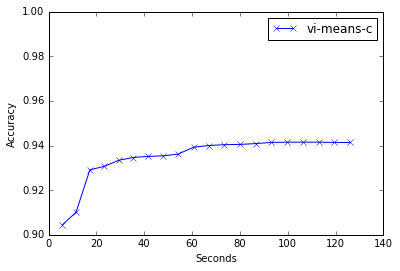

In [49]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
vi_x_lst, vi_y_lst = vi_res.plot_performance(metric, 't', freq=1)
plt.plot(vi_x_lst[1:], vi_y_lst[1:], '-bx', label='vi-means-c')
# plt.plot(svi_x_lst[1:100], svi_y_lst[1:100], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.9, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

### Taylor
Подбор числа пересчетов

In [7]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi')
opts = {'bound': 'Taylor', 'maxfun':5, 'mydisp': True, 'num_updates':3}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=20)

Hyper-parameters at iteration 0 : [ 10.   20.    0.1]
Hyper-parameters at iteration 1 : [ 15.43672779  15.600007     0.08019013]
Hyper-parameters at iteration 2 : [  1.67454905e+01   1.39006917e+01   1.00000000e-02]
	Hyper-parameters at outter iteration 0 : [  1.50240713e+01   1.54041292e+01   1.00000000e-02]
Hyper-parameters at iteration 0 : [  1.50240713e+01   1.54041292e+01   1.00000000e-02]
	Hyper-parameters at outter iteration 1 : [  1.50244020e+01   1.54040148e+01   1.00000000e-02]
Hyper-parameters at iteration 0 : [  1.50244020e+01   1.54040148e+01   1.00000000e-02]
	Hyper-parameters at outter iteration 2 : [  1.50253865e+01   1.54037589e+01   1.00000000e-02]
Hyper-parameters at iteration 0 : [  1.50253865e+01   1.54037589e+01   1.00000000e-02]
Hyper-parameters at iteration 1 : [  2.73620806e+01   1.23041019e+01   1.00000000e-02]
	Hyper-parameters at outter iteration 3 : [  2.73672375e+01   1.23027971e+01   1.00000000e-02]
Hyper-parameters at iteration 0 : [  2.73672375e+01   1.

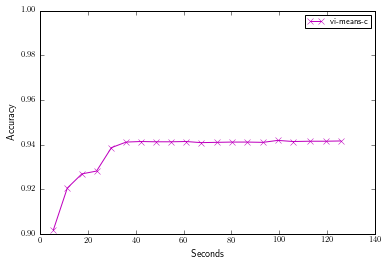

In [8]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
vi_t_x_lst, vi_t_y_lst = vi_res.plot_performance(metric, 't', freq=1)
plt.plot(vi_t_x_lst[1:], vi_t_y_lst[1:], '-mx', label='vi-means-c')
# plt.plot(svi_x_lst[1:100], svi_y_lst[1:100], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([.9, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

### JJ-full
#### Standard

In [65]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi_full')
opts = {'maxiter':50, 'mydisp': True, 'hybrid': False}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Standard mode
Hyper-parameters at iteration 0 : [ 10.   20.    0.1   1.    1. ]
Hyper-parameters at iteration 1 : [ 17.18610928  13.47387237   0.07061773   1.01520532   1.01452459]
Hyper-parameters at iteration 2 : [  1.89013696e+01   1.19079634e+01   1.00000000e-02   1.01903986e+00
   1.01819814e+00]
Hyper-parameters at iteration 3 : [  1.66532717e+01   1.39520669e+01   1.00000000e-02   1.01424214e+00
   1.01361301e+00]
Hyper-parameters at iteration 4 : [  1.67478852e+01   1.38661400e+01   1.00000000e-02   1.01444973e+00
   1.01381161e+00]
Hyper-parameters at iteration 5 : [  1.68450212e+01   1.37780870e+01   1.00000000e-02   1.01466643e+00
   1.01401905e+00]
Hyper-parameters at iteration 6 : [  1.71263990e+01   1.35230659e+01   1.00000000e-02   1.01531522e+00
   1.01464087e+00]
Hyper-parameters at iteration 7 : [  1.71341354e+01   1.35160485e+01   1.00000000e-02   1.01533386e+00
   1.01465876e+00]
Hyper-parameters at iteration 8 : [  1.65945362e+01   1.18647457e+01   1.00000000e-02  

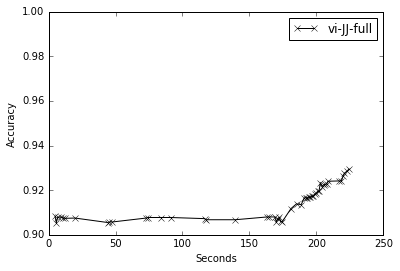

In [66]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_tr, y_tr, x_test, y_test)
vi_full_x_lst, vi_full_y_lst = vi_res.plot_performance(metric, 't', freq=1)
plt.plot(vi_full_x_lst[1:], vi_full_y_lst[1:], '-kx', label='vi-JJ-full')
plt.ylim([0.9, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

#### Hybrid

In [71]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi_full')
opts = {'mydisp': True, 'hybrid': True, 'maxfun':5, 'maxoutiter': 10}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Hybrid mode
	Analytic updates number:3
Hyper-parameters at iteration 0 : [ 10.   20.    0.1   1.    1. ]
Hyper-parameters at iteration 1 : [ 17.18610928  13.47387237   0.07061773   1.01520532   1.01452459]
Hyper-parameters at iteration 2 : [  1.89013696e+01   1.19079634e+01   1.00000000e-02   1.01903986e+00
   1.01819814e+00]
Hyper-parameters at iteration 0 : [  1.66532717e+01   1.39520669e+01   1.00000000e-02   2.52596146e+00
   2.52813241e+00]
Hyper-parameters at iteration 1 : [  1.75388119e+01   1.35188085e+01   1.00000000e-02   2.52649599e+00
   2.52870891e+00]
Hyper-parameters at iteration 2 : [  2.03654764e+01   1.21370202e+01   1.00000000e-02   2.52820387e+00
   2.53055061e+00]
Hyper-parameters at iteration 0 : [  2.03953962e+01   1.21224517e+01   1.00000000e-02   2.93516604e+00
   2.92965648e+00]
Hyper-parameters at iteration 1 : [  2.11228057e+01   1.14589955e+01   1.00000000e-02   2.93571034e+00
   2.93023218e+00]
Hyper-parameters at iteration 2 : [  2.14435743e+01   1.116695

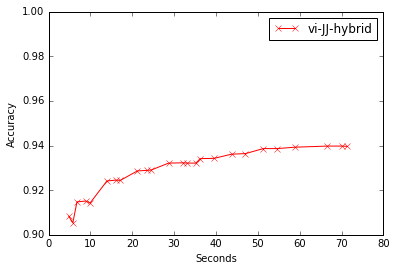

In [72]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_tr, y_tr, x_test, y_test)
vi_h_x_lst, vi_h_y_lst = vi_res.plot_performance(metric, 't', freq=1)
plt.plot(vi_h_x_lst[1:], vi_h_y_lst[1:], '-rx', label='vi-JJ-hybrid')
plt.ylim([0.9, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## svi-AdaDelta-c
Подбор длины шага

In [20]:
results = []
steps = [1.2, 1.1, 1.]
for step in steps:
    print(step)
    model_covariance_obj = SquaredExponential(np.copy(cov_params))
    ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)

    opts = {'mode': 'adadelta', 'maxiter': 20, 'verbose': False, 'batch_size': 350, 
            'step_rate': step}#, 'print_freq':50}
    batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)
    results.append(batch_res)

1.2
1.1
1.0


/Users/IzmailovPavel/Documents/Education/Course Project/Code/GP/gaussian_process_classification.py:614: RuntimeWarning: invalid value encountered in log
  loss += np.sum(np.log(np.diag(sigma_L))) * l / N


0
1
2


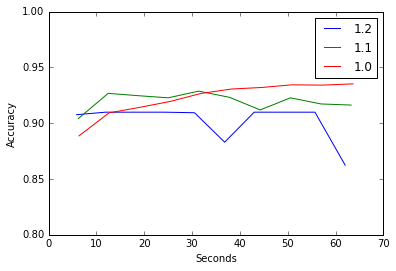

In [21]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
for i in range(len(results)):
    svi_ad_x_lst, svi_ad_y_lst = results[i].plot_performance(metric, 't', freq=1)
    plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], label=steps[i])
    print(i)
plt.ylim([0.8, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [22]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)
opts = {'mode': 'adadelta', 'maxiter': 30, 'verbose': True, 'batch_size': 350, 
        'step_rate': 1., 'print_freq':1}
batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Using AdaDelta optimizer
Iteration  1 :
	Gradient norm 8.8346584206
Iteration  2 :
	Gradient norm 7.19278907977
Iteration  3 :
	Gradient norm 13.3856414634
Iteration  4 :
	Gradient norm 7.87188241742
Iteration  5 :
	Gradient norm 8.43101824246
Iteration  6 :
	Gradient norm 19.320388366
Iteration  7 :
	Gradient norm 8.11076290142
Iteration  8 :
	Gradient norm 9.9716405351
Iteration  9 :
	Gradient norm 12.652559551
Iteration  10 :
	Gradient norm 12.7613938602
Iteration  11 :
	Gradient norm 8.5814728066
Iteration  12 :
	Gradient norm 23.599347291
Iteration  13 :
	Gradient norm 7.91119979681
Iteration  14 :
	Gradient norm 8.89976175494
Iteration  15 :
	Gradient norm 12.3944426749
Iteration  16 :
	Gradient norm 7.5457788762
Iteration  17 :
	Gradient norm 8.01256424602
Iteration  18 :
	Gradient norm 13.4304652137
Iteration  19 :
	Gradient norm 7.75074626901
Iteration  20 :
	Gradient norm 6.45421833831
Iteration  21 :
	Gradient norm 12.9885841569
Iteration  22 :
	Gradient norm 8.38827451034
I

/Users/IzmailovPavel/Documents/Education/Course Project/Code/GP/gaussian_process_classification.py:614: RuntimeWarning: invalid value encountered in log
  loss += np.sum(np.log(np.diag(sigma_L))) * l / N


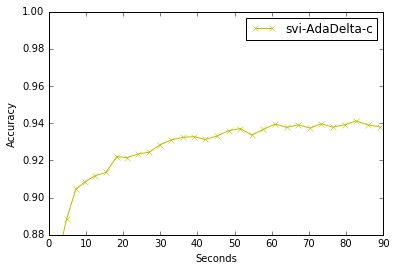

In [23]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
svi_ad_x_lst, svi_ad_y_lst = batch_res.plot_performance(metric, 't', freq=1)
plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], '-yx', label='svi-AdaDelta-c')
plt.ylim([0.88, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## Выводы

In [51]:
svi_x_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_svi_x.npy')
svi_y_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_svi_y.npy')
svi_ad_y_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_ad_y.npy')
svi_ad_x_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_ad_x.npy')
vi_x_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_vi_x.npy')
vi_y_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_vi_y.npy')
vi_t_x_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_vi_t_x.npy')
vi_t_y_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_vi_t_y.npy')

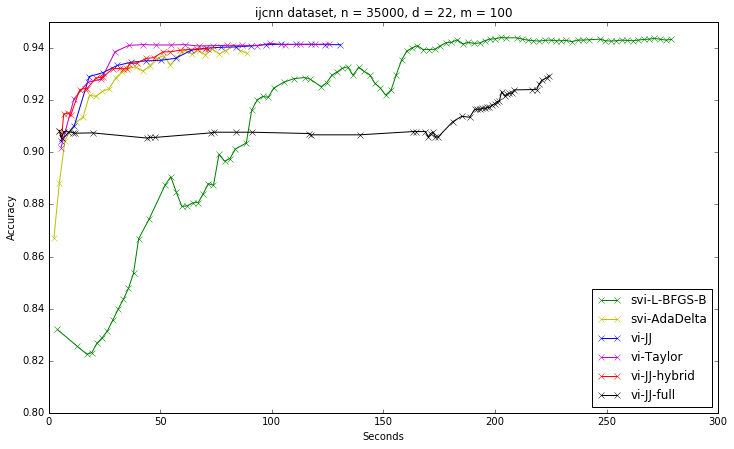

In [82]:
plt.figure(figsize=(12, 7))
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B')
plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], '-yx', label='svi-AdaDelta')
plt.plot(vi_x_lst[1:], vi_y_lst[1:], '-bx', label='vi-JJ')
plt.plot(vi_t_x_lst[1:], vi_t_y_lst[1:], '-mx', label='vi-Taylor')
plt.plot(vi_h_x_lst[1:], vi_h_y_lst[1:], '-rx', label='vi-JJ-hybrid')
plt.plot(vi_full_x_lst[1:], vi_full_y_lst[1:], '-kx', label='vi-JJ-full')
plt.ylim([0.8, .95])
plt.legend(loc=4)
plt.xlabel('Seconds')
plt.ylabel('Accuracy')
plt.title(data_name+' dataset, n = ' + str(num) + ', d = ' + str(dim) + ', m = '+ str(ind_num))

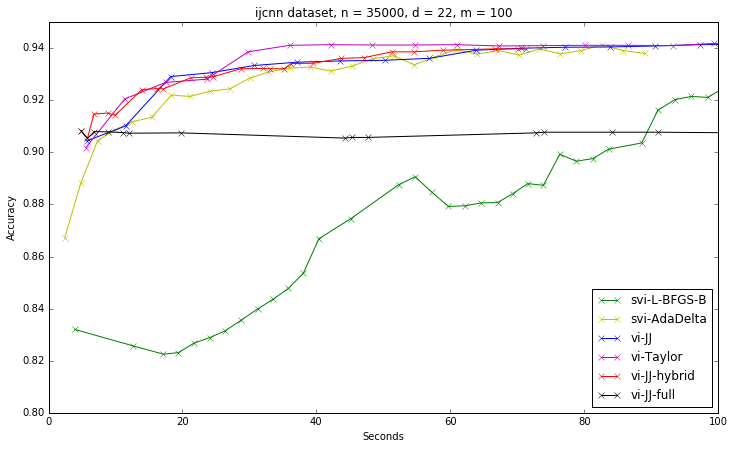

In [83]:
plt.figure(figsize=(12, 7))
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B')
plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], '-yx', label='svi-AdaDelta')
plt.plot(vi_x_lst[1:], vi_y_lst[1:], '-bx', label='vi-JJ')
plt.plot(vi_t_x_lst[1:], vi_t_y_lst[1:], '-mx', label='vi-Taylor')
plt.plot(vi_h_x_lst[1:], vi_h_y_lst[1:], '-rx', label='vi-JJ-hybrid')
plt.plot(vi_full_x_lst[1:], vi_full_y_lst[1:], '-kx', label='vi-JJ-full')
plt.ylim([0.8, .95])
plt.xlim([0, 100])
plt.legend(loc=4)
plt.xlabel('Seconds')
plt.ylabel('Accuracy')
plt.title(data_name+' dataset, n = ' + str(num) + ', d = ' + str(dim) + ', m = '+ str(ind_num))

In [84]:
data_name

'ijcnn'

In [86]:
np.save('../plots/vi_vs_svi_class/'+ data_name +'/svi_x.npy', svi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/svi_y.npy', svi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/ad_x.npy', svi_ad_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/ad_y.npy', svi_ad_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/vi_x.npy', vi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/vi_y.npy', vi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/vi_t_x.npy', vi_t_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/vi_t_y.npy', vi_t_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/vi_h_x.npy', vi_h_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/vi_h_y.npy', vi_h_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/vi_f_x.npy', vi_full_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/vi_f_y.npy', vi_full_y_lst)